<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/Bayesian_NN_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Bayesian Regression with NN

A neural network regression example with Monte Carlo dropout.

In [96]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.3 MB/s 


In [97]:
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk
import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Create a data set

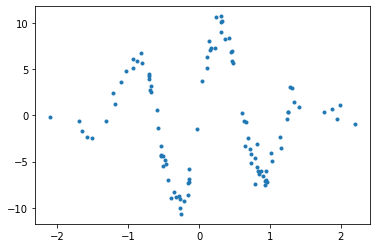

In [43]:
n_obs = 100
X = np.random.normal(size=(n_obs))
y = np.random.normal(10.*np.sin(X/0.2)*np.exp(-X**2/2))

plt.plot(X, y, '.')

Create a simple model

In [124]:
class MonteCarloDropout(tfkl.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

model = tfk.models.Sequential()
model.add(tfkl.InputLayer(input_shape=(1,)))
model.add(tfkl.Dense(128, activation=tfkl.ReLU()))
model.add(MonteCarloDropout(0.2))
model.add(tfkl.Dense(64, activation=tfkl.ReLU()))
model.add(MonteCarloDropout(0.2))
model.add(tfkl.Dense(32, activation=tfkl.ReLU()))
model.add(MonteCarloDropout(0.2))                           
model.add(tfkl.Dense(1))

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 128)               256       
                                                                 
 monte_carlo_dropout_35 (Mon  (None, 128)              0         
 teCarloDropout)                                                 
                                                                 
 dense_72 (Dense)            (None, 64)                8256      
                                                                 
 monte_carlo_dropout_36 (Mon  (None, 64)               0         
 teCarloDropout)                                                 
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 monte_carlo_dropout_37 (Mon  (None, 32)             

In [125]:
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-2, weight_decay=1e-5),
              loss='mse',
              metrics='mse')

history = model.fit(X, y, epochs=150)

Epoch 1/150
4/4 [==============================] - 1s 3ms/step - loss: 32.2371 - mse: 32.2371
Epoch 2/150
4/4 [==============================] - 0s 3ms/step - loss: 31.4857 - mse: 31.4857
Epoch 3/150
4/4 [==============================] - 0s 3ms/step - loss: 31.2385 - mse: 31.2385
Epoch 4/150
4/4 [==============================] - 0s 3ms/step - loss: 31.4236 - mse: 31.4236
Epoch 5/150
4/4 [==============================] - 0s 3ms/step - loss: 30.8728 - mse: 30.8728
Epoch 6/150
4/4 [==============================] - 0s 3ms/step - loss: 29.6855 - mse: 29.6855
Epoch 7/150
4/4 [==============================] - 0s 3ms/step - loss: 27.5231 - mse: 27.5231
Epoch 8/150
4/4 [==============================] - 0s 3ms/step - loss: 26.0954 - mse: 26.0954
Epoch 9/150
4/4 [==============================] - 0s 3ms/step - loss: 24.7415 - mse: 24.7415
Epoch 10/150
4/4 [==============================] - 0s 3ms/step - loss: 23.3948 - mse: 23.3948
Epoch 11/150
4/4 [==============================] - 0s 3ms/

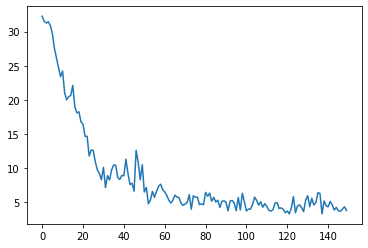

In [126]:
plt.plot(history.history['loss'])

Generate multiple predictions with Dropout turned on during model predicition stage.

In [133]:
x_pred = np.linspace(-3,3,100)

n_preds = 1000
pred = []
for i in range(n_preds):
  pred.append(model(x_pred, training=True))



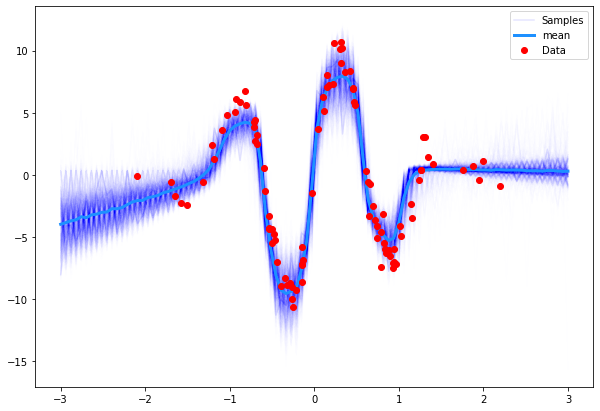

In [136]:
plt.figure(figsize=(10,7))
plt.plot(x_pred, np.array(pred).T[0][:,0], 'blue', alpha=0.1, label='Samples')
plt.plot(x_pred, np.array(pred).T[0], 'blue', alpha=1/500)
plt.plot(x_pred, np.array(pred).T[0].mean(axis=1), 'dodgerblue', lw=3, label='mean')
plt.plot(X, y, 'ro', label='Data')
plt.legend()

In [141]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

In [142]:
pred = np.array(pred).T[0]

In [143]:
hdi_min= np.zeros(pred.shape[0])
hdi_max= np.zeros(pred.shape[0])

for i in range(pred.shape[0]):
  hdi_min[i], hdi_max[i] = hpd(pred[i])

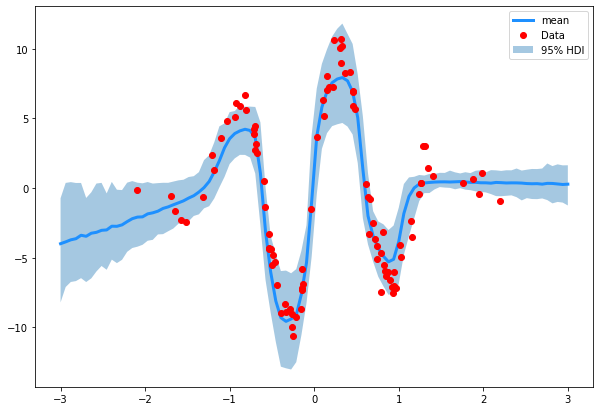

In [147]:
plt.figure(figsize=(10,7))
plt.plot(x_pred, pred.mean(axis=1), 'dodgerblue', lw=3, label='mean')

plt.fill_between(x_pred, hdi_min, hdi_max, alpha=0.4, label='95% HDI')
plt.plot(X, y, 'ro', label='Data')
plt.legend()